In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [15, 10]


def getIdxOfFreq(freq, targetFreq):
    """helper to find the index of a given frequency"""
    return np.array(np.abs(freq-targetFreq)).argmin()

def loadAllfiles(filenames):
    """ reading in the data, bringing it to linear scale """
    freq = None
    data = []
    for filename in filenames:
        dataIn = pd.read_csv(filename,header=4, delimiter=",").values
        if freq is None:
            freq = dataIn[:,0]
        data.append(np.array(dataIn[:,1]))
    
    data = np.array(data)

    data = 10**(data/10)
    return freq,data

load in all the data. Every second data set is "key sending", each other is "no key sending", so deduce from number (last digit) in filename

In [2]:
filenamesA = []
filenamesB = []

DATA_FOLDER = os.path.join("..", "DownloadedData", "AntennaSpectra")

In [3]:
path = os.path.join(DATA_FOLDER, "20220725_1")

filenamesA = []
filenamesB = []

filenamesA.extend([os.path.join(path, filename) for filename in os.listdir(path) if os.path.isfile(os.path.join(path, filename)) and 'SpecAn1--' in filename and int(filename[-5])%2==0])
filenamesB.extend([os.path.join(path, filename) for filename in os.listdir(path) if os.path.isfile(os.path.join(path, filename)) and 'SpecAn1--' in filename and int(filename[-5])%2!=0])

path = os.path.join(DATA_FOLDER, "20220725_2")
filenamesA.extend([os.path.join(path, filename) for filename in os.listdir(path) if os.path.isfile(os.path.join(path, filename)) and 'SpecAn1--' in filename and int(filename[-5])%2==0])
filenamesB.extend([os.path.join(path, filename) for filename in os.listdir(path) if os.path.isfile(os.path.join(path, filename)) and 'SpecAn1--' in filename and int(filename[-5])%2!=0])

frequencies to filter out (Wifi, etc.)

In [4]:
#freqFilter=[[925,960],[1805,1990],[1500,1600],[2400,2483.5],[85,110],[177.5,226.5],[462.5,467.8],[474,786]]
freqFilter=[[0,0]]

def filterData(freq, data):
    """ remove known radio frequencies"""
    mindata = np.min(data)
    for f in freqFilter:
        fmin = getIdxOfFreq(freq, f[0]*1_000_000)-1
        fmax = getIdxOfFreq(freq, f[1]*1_000_000)+1
        if fmin <0:
            fmin=0
        if fmax>len(data):
            fmax = len(data)
        data[fmin:fmax] = mindata
    return data

load the data

In [5]:
numdata = np.min([len(filenamesA),len(filenamesB)])
freq,dataA=loadAllfiles(filenamesA[:numdata])
freq,dataB=loadAllfiles(filenamesB[:numdata])

show entire spectrum

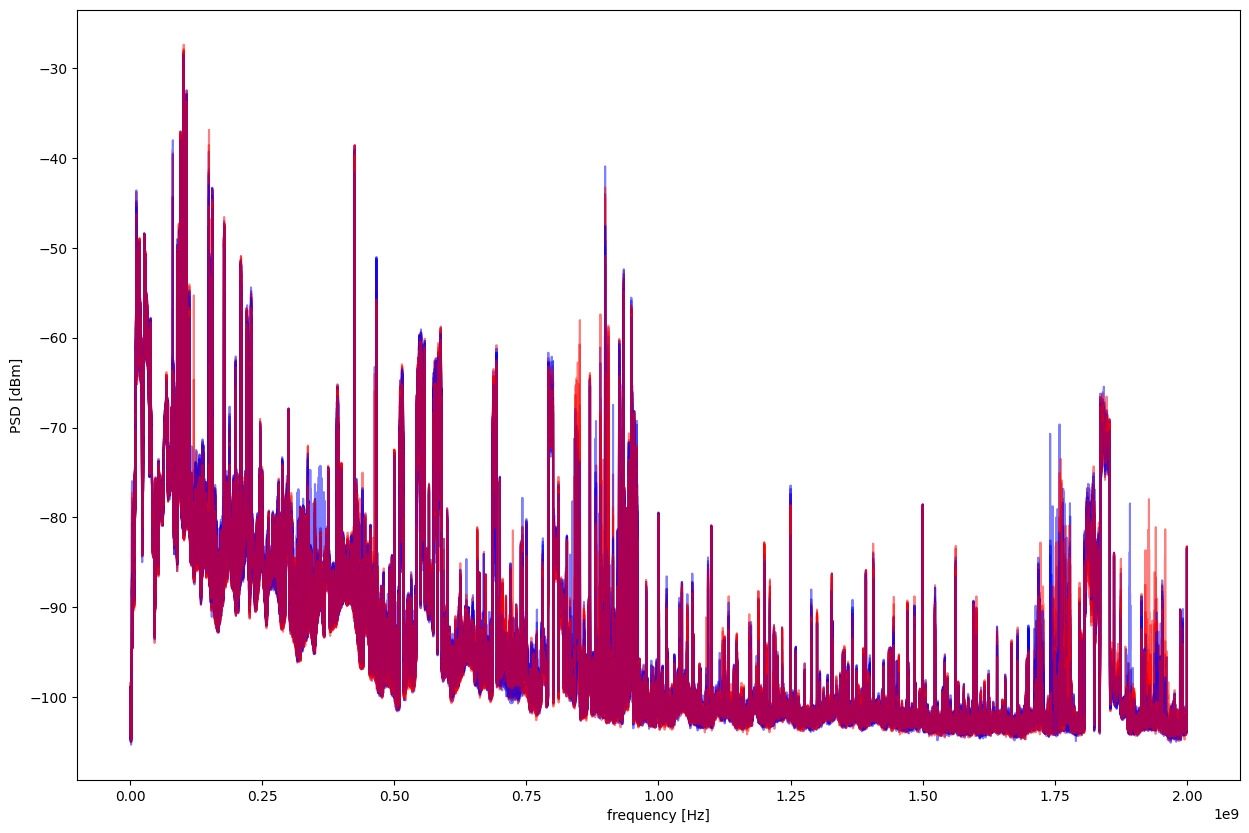

In [6]:
plt.rcParams['figure.figsize'] = [15, 10]

alphaval = 0.5

for i in range(10):
    plt.plot(freq, 10*np.log10(dataA[i]),'b',alpha=alphaval)
    plt.plot(freq, 10*np.log10(dataB[i]),'r',alpha=alphaval)
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dBm]")
plt.savefig("measured_signals.png", dpi=300)
plt.show()

filter out annoying frequency ranges

In [7]:
for i in range(len(dataA)):
    dataA[i] = filterData(freq, dataA[i])
for i in range(len(dataB)):
    dataB[i] = filterData(freq, dataB[i])

do some data inspection: entire range and some smaller intervals

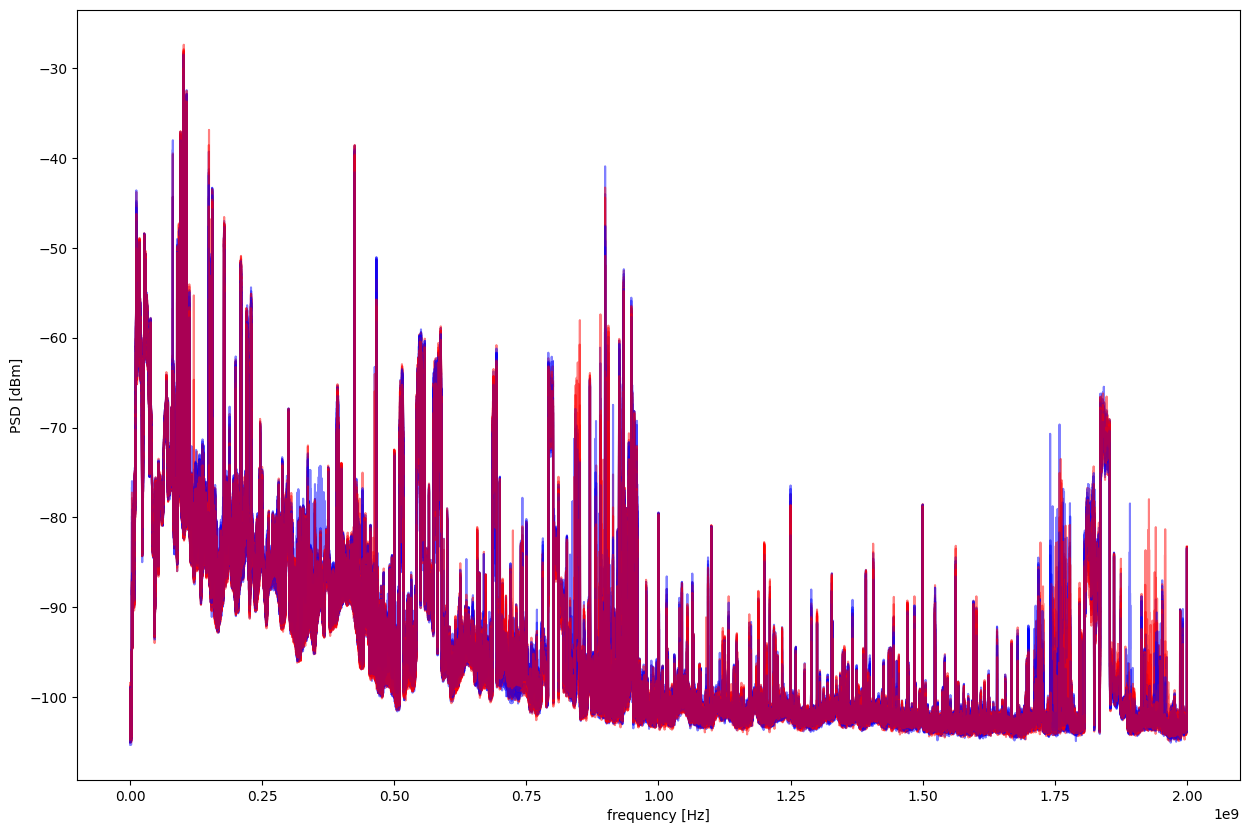

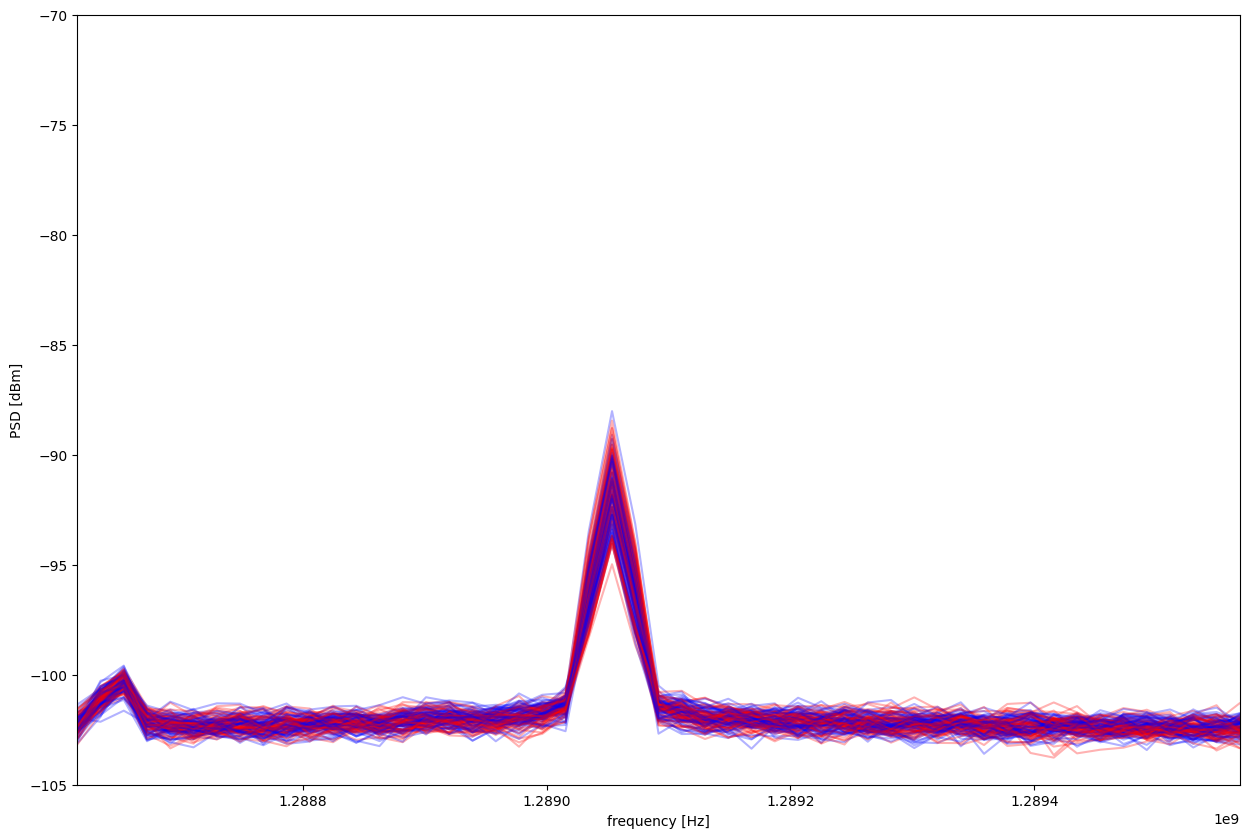

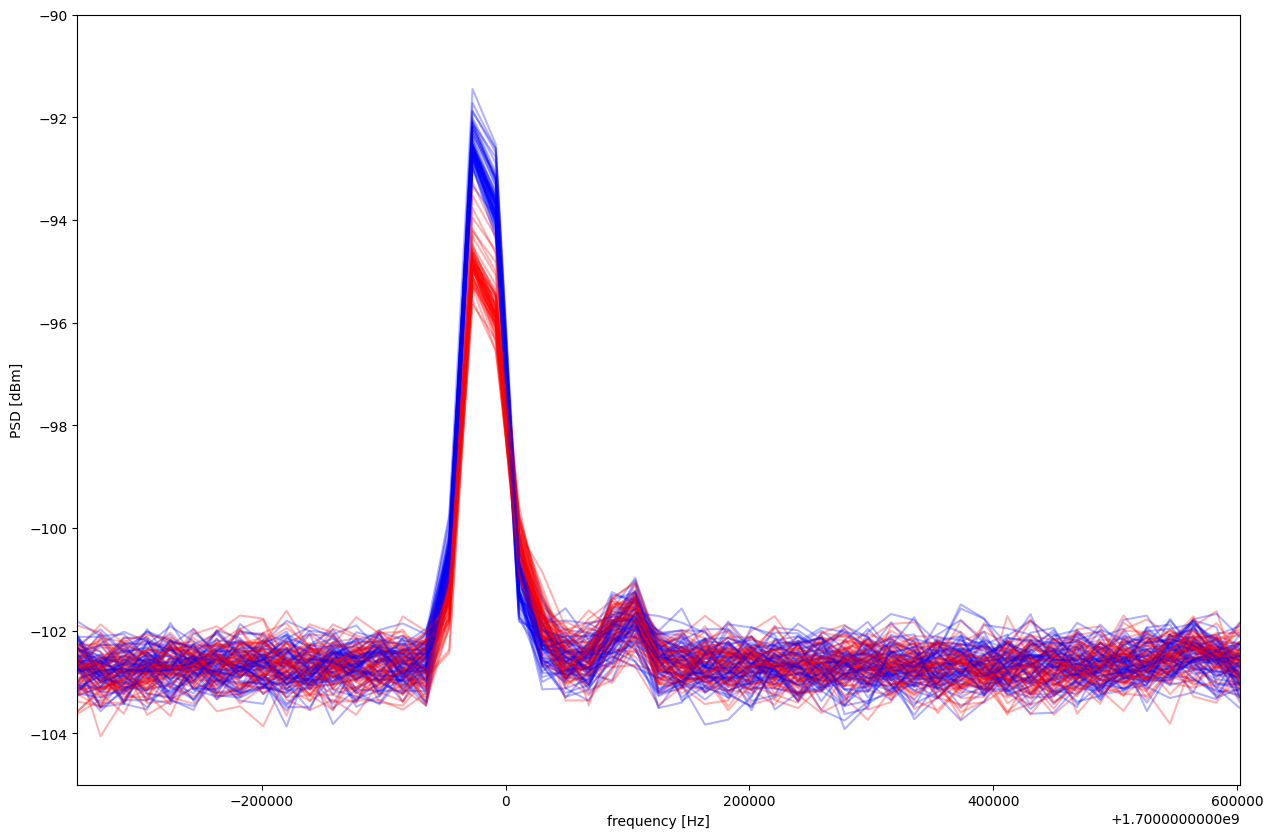

In [8]:
alphaval = 0.5

for i in range(10):
    plt.plot(freq, 10*np.log10(dataA[i]),'b',alpha=alphaval)
    plt.plot(freq, 10*np.log10(dataB[i]),'r',alpha=alphaval)
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dBm]")
plt.savefig("measured_signals_freqRemoved.png", dpi=300)
plt.show()

alphaval = 0.3

for i in range(60):
    plt.plot(freq, 10*np.log10(dataA[i]),'b',alpha=alphaval)
    plt.plot(freq, 10*np.log10(dataB[i]),'r',alpha=alphaval)
plt.xlim(freq[67550],freq[67600])
plt.ylim(-105,-70)
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dBm]")
plt.savefig("measured_signals_cut1.png", dpi=300)
plt.show()

for i in range(60):
    plt.plot(freq, 10*np.log10(dataA[i]),'b',alpha=alphaval)
    plt.plot(freq, 10*np.log10(dataB[i]),'r',alpha=alphaval)
plt.xlim(freq[89100],freq[89150])
plt.ylim(-105,-90)
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dBm]")
plt.savefig("measured_signals_cut2.png", dpi=300)
plt.show()

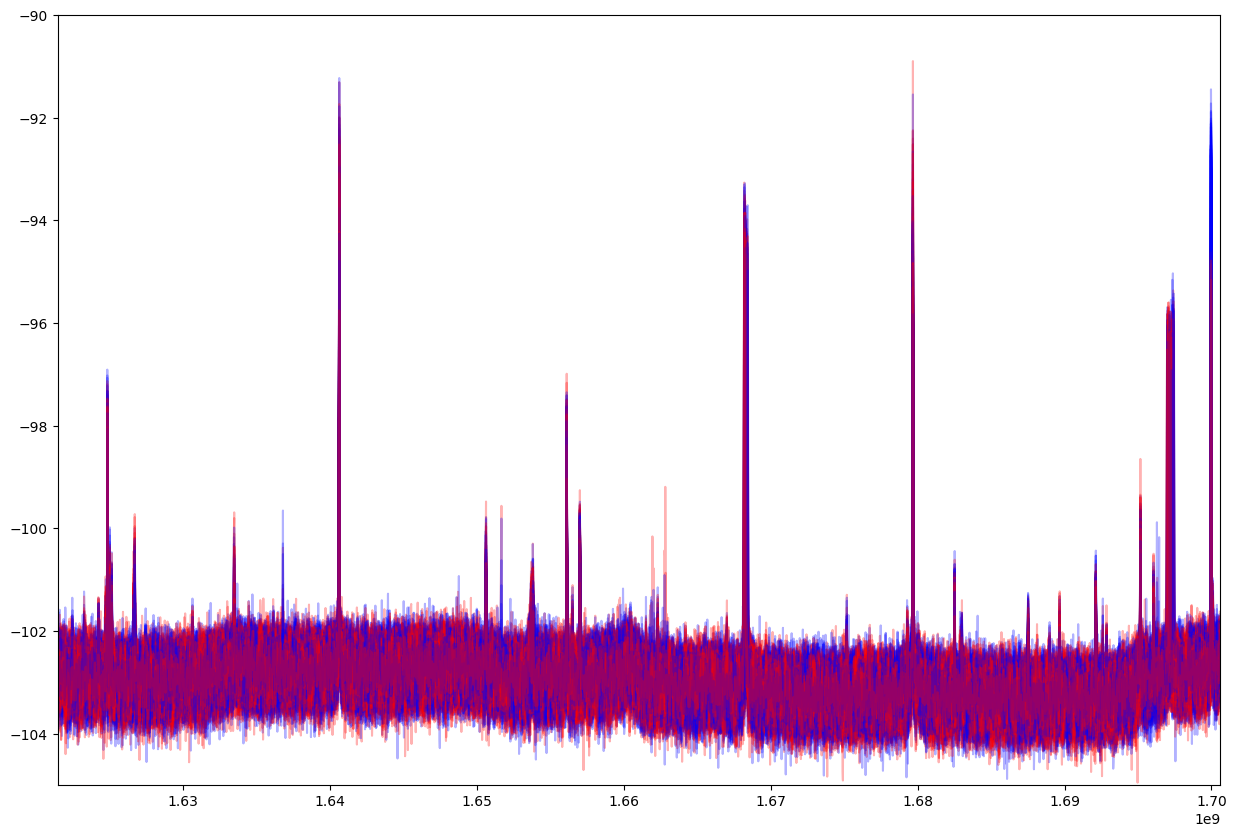

In [9]:
rangemin = 85000
rangemax = 89150
for i in range(60):
    plt.plot(freq, 10*np.log10(dataA[i]),'b',alpha=alphaval)
    plt.plot(freq, 10*np.log10(dataB[i]),'r',alpha=alphaval)
plt.xlim(freq[rangemin],freq[rangemax])
plt.ylim(-105,-90)
plt.show()

merging the two data sets and create a label array

In [10]:
data = []
y = []
for i in range(numdata):
    #data.append(np.array([dataA[i][89100:89150]]))
    data.append(np.array(np.concatenate([dataA[i][89100:89150],dataA[i][67560:67580]])))
    y.append(0)
    #data.append(np.array([dataB[i][89100:89150]]))
    data.append(np.array(np.concatenate([dataB[i][89100:89150],dataB[i][67560:67580]])))
    y.append(1)
data = np.array(data)
#data = data.reshape(len(data),len(data[0][0]))

do a train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=0)

let's try an SVC and a KNN model

In [12]:
SVC_model = svm.SVC()
KNN_model = KNeighborsClassifier(n_neighbors=2)
LDA_model = LinearDiscriminantAnalysis()

SVC_model.fit(X_train, y_train)
KNN_model.fit(X_train, y_train)
LDA_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [13]:
SVC_prediction = SVC_model.predict(X_test)
KNN_prediction = KNN_model.predict(X_test)
LDA_prediction = LDA_model.predict(X_test)

In [14]:
# Accuracy score is the simplest way to evaluate
print(accuracy_score(SVC_prediction, y_test))
print(accuracy_score(KNN_prediction, y_test))
print(accuracy_score(LDA_prediction, y_test))

# But Confusion Matrix and Classification Report give more details about performance
print(confusion_matrix(SVC_prediction, y_test))
print(classification_report(KNN_prediction, y_test))
print(classification_report(LDA_prediction, y_test))

0.9574468085106383
0.9468085106382979
0.9893617021276596
[[42  3]
 [ 1 48]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        46
           1       0.92      0.98      0.95        48

    accuracy                           0.95        94
   macro avg       0.95      0.95      0.95        94
weighted avg       0.95      0.95      0.95        94

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.98      0.99        52

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       0.99      0.99      0.99        94



In [15]:
matplotlib.rcParams['figure.figsize'] = [6.9,2]

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
# matplotlib.rcParams['lines.marker']  #None
matplotlib.rcParams['lines.markersize'] = 2 #6.0
matplotlib.rcParams['lines.linewidth'] = 1   # 1.5
matplotlib.rcParams['figure.constrained_layout.use'] = True

In [16]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

/tmp/ipykernel_285199/347662257.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


No handles with labels found to put in legend.
/tmp/ipykernel_285199/27725435.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x/1e6) for x in ax.get_xticks()])
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


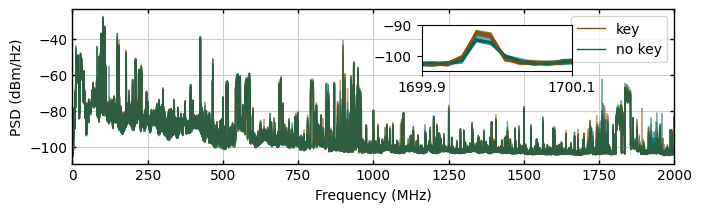

In [17]:
alphaval = 0.5

fig, ax = plt.subplots()

# Set the grid
#ax.set_ylim([20, 100])
ax.set_xlim([0, 2e9])

#ax.xaxis.set_major_locator(MultipleLocator(2))
#ax.yaxis.set_major_locator(MultipleLocator(20))

#ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#ax.yaxis.set_minor_locator(AutoMinorLocator(2))

axesthickness = 1

ax.xaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=3, width=axesthickness, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=2, width=axesthickness, direction='in', right='on')#

ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')

ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True)
ax.set_ylabel("PSD (dBm/Hz)")
ax.set_xlabel("Frequency (MHz)")
#ax.yaxis.set_ticks([25,40,60,80,100])
#ax.set_title(title)


# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(axesthickness)

# increase tick width
ax.tick_params(width=axesthickness)

font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 10}

plt.rc('font', **font)

ax.plot(freq, 10*np.log10(dataA[i]),alpha=alphaval, label='key', color="#8c510aff")
ax.plot(freq, 10*np.log10(dataB[i]),alpha=alphaval, label='no key', color="#01665eff")
for i in range(5):
    ax.plot(freq, 10*np.log10(dataA[i+1]),alpha=alphaval, color="#8c510aff")
    ax.plot(freq, 10*np.log10(dataB[i+1]),alpha=alphaval, color="#01665eff")
#plt.xlabel("frequency [Hz]")
#plt.ylabel("PSD [dBm]")


# Create a set of inset Axes: these should fill the bounding box allocated to them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.58,0.6,0.25,0.3])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
for i in range(30):
    ax2.plot(freq, 10*np.log10(dataA[i]),alpha=alphaval, color="#8c510aff")
    ax2.plot(freq, 10*np.log10(dataB[i]),alpha=alphaval, color="#01665eff")
#ax2.set_xlim([freq[89110],freq[89130]])
ax2.set_xlim([1699900000,1700100000])
ax2.set_ylim([-105,-90])
#ax2.xaxis.set_ticks([freq[89110],freq[89130]])
ax2.xaxis.set_ticks([1699900000,1700100000])
ax2.set_xticklabels([(x/1e6) for x in ax2.get_xticks()])
mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec=None)
ax.set_xticklabels([int(x/1e6) for x in ax.get_xticks()])
ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=True)
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)


plt.savefig("antenna_spectrum.pdf")
plt.show()

In [18]:
freq[89110]

1699839290.0

In [19]:
freq[89130]

1700220760.0